### AdaBoost的一般流程
（1）收集数据：可以使用任意方法。  
（2）准备数据：依赖于所使用的弱分类器类型，本章使用的是单层决策树，这种分类器可以处理任何数据类型。当然也可以使用任意分类器作为弱分类器，作为弱分类器，简单分类器的效果更好。  
（3）分析数据：可以使用任意方法。  
（4）训练算法：AdaBoost的大部分时间都用在训练上，分类器将多次在同一数据集上训练弱分类器。  
（5）测试算法：计算分类的错误率。  
（6）使用算法：同SVM一样，AdaBoost预测两个类别中的一个。如果想把它应用到多个类别的场合，那么就要像多类SVM中的做法一样对AdaBoost进行修改。

#### AdaBoost（Adaptive boosting）的运行过程：
- 训练数据中的每个样本，并赋予其一个权重，这些权重构成了向量$D$。  
- 一开始，这些权重都初始化成相等值。  
- 首先，在训练数据上训练出一个弱分类器并计算该分类器的错误率，然后在同一数据集上再次训练弱分类器。  
- 在分类器的第二次训练当中，将会重新调整每个样本的权重，其中第一次分对的样本的权重将会降低，而第一次分错的样本的权重将会提高。  
- 为了从所有弱分类器中得到最终的分类结果，AdaBoost为每个分类器都分配了一个权重值alpha，这些alpha值是基于每个弱分类器的错误率进行计算的。

其中，错误率$ε$的定义为：
$$ε=\frac{未正确分类的样本数目}{所有样本数目}$$
而alpha的计算公式如下： 
$$α= \frac{1}{2}ln(\frac{1-ε}{ε})$$
计算出alpha值之后，可以对权重向量$D$进行更新，以使那些正确分类的样本的权重降低而错分样本的权重升高。$D$的计算方法如下： 
如果某个样本被正确分类，那么该样本的权重更改为： 
$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{-α}}{Sum(D)}$$
而如果某个样本被错分，那么该样本的权重更改为;  
$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{α}}{Sum(D)}$$
在计算出$D$之后，AdaBoost又开始下一轮迭代。AdaBoost算法会不断重复训练和调整权重的过程，直到错误率为0或者弱分类器的数目达到用户的指定值为止。

In [90]:
import numpy as np
"""
函数说明:加载数据

Parameters:
    无
Returns:
    datMat - 数据列表
    classLabels - 标签列表
"""
def loadSimpData():
    datMat = np.matrix([[1.,2.1],
                        [2.,1.1],
                        [1.3,1.],
                        [1.,1.],
                        [2.,1.]])
    classLabels = [1.0,1.0,-1.0,-1.0,1.0]
    return datMat,classLabels

In [91]:
"""
函数说明:单层决策树分类函数

Parameters:
    dataMatrix - 数据矩阵
    dimen - 第dimen列，即第dimen个特征
    threshVal - 阈值
    threshIneq - 标志，lt--less than；gt--great than
Returns:
    retArray - 分类结果
"""
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones((dataMatrix.shape[0],1))     #将分类结果初始化为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0   #如果小于阈值，则分类结果为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0    #如果大于阈值，则分类结果为-1
    return retArray

In [92]:
"""
函数说明:找到数据集上最佳的单层决策树

Parameters:
    dataArr - 数据列表
    classLabels - 标签列表
    D - 样本权重
Returns:
    bestStump - 最佳单层决策树信息
    minError - 最小错误率
    bestClassEst - 最佳分类结果
"""
def buildStump(dataArr, classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T  #将训练数据和标签列表转换为numpy矩阵
    m,n = np.shape(dataMatrix)  #返回训练数据的大小
    numSteps = 10.0; bestStump = {}; bestClassEst = np.mat(np.zeros((m,1))) #初始化
    minError = np.inf   #将最小错误率设置为无穷大
    for i in range(n):  #遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()  #找到特征中最小和最大的值
        stepSize = (rangeMax-rangeMin)/numSteps #计算步长
        for j in range(-1,int(numSteps)+1):
            for inequal in ['lt','gt']:     #遍历大于和小于的情况
                threshVal = (rangeMin+float(j)*stepSize)    #计算阈值
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)   #计算分类结果
                errArr = np.mat(np.ones((m,1)))     #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0   #若预测正确，赋值为0
                weightedError = D.T*errArr  #计算加权误差率
                #print("split: dim  %d, thresh  %.2f, thresh ineqal: %s, the weighted error is %.3f" %\
                 #     (i, threshVal,inequal,weightedError))
                if weightedError < minError:    #找到误差最小的分类方式
                    minError = weightedError
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] = i    #将最佳单层决策树的信息存至字典
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClassEst

In [93]:
"""
函数说明:基于单层决策树的AdaBoost训练过程

Parameters:
    dataArr - 数据集
    classLabels - 类别标签
    numIt - 迭代次数
Returns:
    weakClassArr - 各层决策树信息
"""
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)    #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))   #记录每个数据点的类别估计累计值
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr,classLabels,D)  #构建单层决策树
        #print("D: ", D.T)
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16))) #根据公式计算弱学习算法权重
        bestStump['alpha'] = alpha  #存储弱学习算法权重
        weakClassArr.append(bestStump)    #存储单层决策树
        #print("classEst: ", classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)    #根据公式计算e的指数项
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()   #根据样本权重公式，更新权重
        aggClassEst += alpha*classEst   #将各数据点的类别估计值累加
       # print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst)!= np.mat(classLabels).T, np.ones((m,1)))   #计算误差
        errorRate = aggErrors.sum()/m
        print("total error:", errorRate,"\n")
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

In [94]:
"""
函数说明:AdaBoost分类函数

Parameters:
    datToClass - 待分类数据集
    classifierArr - 训练好的多个弱分类器数组
Returns:
    分类结果
"""
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass) #将待分类数据集转换为numpy矩阵
    m = np.shape(dataMatrix)[0] #求得待分类数据的样本数
    aggClassEst = np.mat(np.zeros((m,1))) #初始化分类结果
    for i in range(len(classifierArr)): #遍历所有的分类器，进行分类
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst   #给样本加上权重
        #print(aggClassEst)
    return np.sign(aggClassEst) #返回分类结果

#### 示例：在一个难数据集上应用AdaBoost
（1）收集数据：提供的文本文件。  
（2）准备数据：确保类别标签是+1和-1而非1和0。  
（3）分析数据：手工检查数据。  
（4）训练算法：在数据上，利用adaBoostTrainDS()函数训练出一系列的分类器。  
（5）测试算法：我们拥有两个数据集。在不采用随机抽样的方法下，我们就会对AdaBoost和Logistic回归的结果进行完全对等的比较。  
（6）使用算法：观察该例子上的错误率。不过，也可以构建一个Web网站，让驯马师输入马的症状然后预测马是否会死去。

In [95]:
"""
函数说明:自适应数据加载函数

Parameters:
    fileName - 文件名
Returns:
    dataMat- 数据集
    labelMat- 标签列表
"""
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))    #获取特征数目
    dataMat = []; labelMat = []
    fr = open(fileName) #打开文件
    for line in fr.readlines(): #逐行读取
        lineArr = []
        curLine = line.strip().split('\t')  #去掉回车，放入列表
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr) #添加数据
        labelMat.append(float(curLine[-1])) #添加标签
    return dataMat,labelMat

In [96]:
dataMat,labelMat = loadDataSet('data/horseColicTraining2.txt')
classifierArray,aggClassEst = adaBoostTrainDS(dataMat,labelMat,10)

total error: 0.284280936455 

total error: 0.284280936455 

total error: 0.247491638796 

total error: 0.247491638796 

total error: 0.254180602007 

total error: 0.240802675585 

total error: 0.240802675585 

total error: 0.220735785953 

total error: 0.247491638796 

total error: 0.230769230769 



In [97]:
testeMat,testLabelMat = loadDataSet('data/horseColicTraining2.txt')
prediction10 = adaClassify(testeMat,classifierArray)
#求得预测错误率
m,n = np.shape(testeMat)
errArr = np.mat(np.ones((m,1)))
errArr = np.multiply((prediction10!=np.mat(testLabelMat).T),errArr)
errRate = errArr.sum()/m
errRate

0.23076923076923078

#### 其他分类性能度量指标：正确率、召回率及ROC曲线
- 混淆矩阵中有真正例（TP）、伪正例（FP）、伪反例（FN）、真反例（TN）
- 正确率为TP/(TP+FP)，给出的是预测为正例的样本中的真正正例的比例。
- 召回率为TP/(TP+FN)，给出的是预测为正例的真实正例占所有真实正例的比例。
- ROC曲线（ROC curve），ROC代表接收者操作特征（receiver operating characteristic）。
- ROC曲线下的面积AUC(Area Under the Curve)给出的是分类器的平均性能值。

In [98]:
"""
函数说明:ROC曲线的绘制及AUC计算函数

Parameters:
    predStrengths - 分类器的预测强度
    classLabels - 标签列表
Returns:
    无
"""
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0)     #绘制光标的位置
    ySum = 0.0          #用于计算AUC
    numPosClas = sum(np.array(classLabels)==1.0)    #统计正类的数量
    yStep = 1/float(numPosClas)                     #确定y轴的步长:TP/(TP+FN)
    xStep = 1/float(len(classLabels)-numPosClas)    #确定x轴的步长：FP/(FP+TN)
    sortedIndicies = predStrengths.argsort()        #得到排序索引
    fig = plt.figure()                              #构建画笔
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:        #在所有排序值上进行循环
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep                  #每得到一个正类，就沿着y轴方向下降一个步长，不断降低真阳率
        else:
            delX =xStep; delY=0                     #其他类就沿着x轴方向倒退一个步长
            ySum += cur[1]                          #计算面积是小矩形的宽度是xStep，高度累加
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print('the Area Under the Curve is: ', ySum*xStep)      #计算AUC


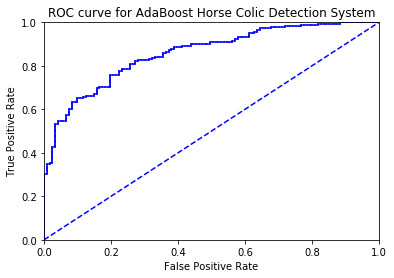

the Area Under the Curve is:  0.8582969635063604


In [99]:
plotROC(aggClassEst.T, labelMat)